In [57]:
import numpy as np
from partition_decode.models import ReluNetClassifier
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals
import torch

In [58]:
X, y = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=0.3
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

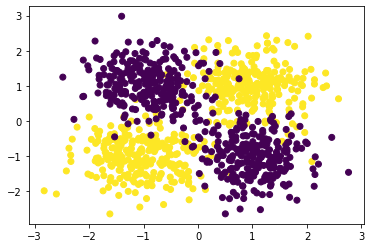

In [59]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [60]:
net = ReluNetClassifier(
    verbose=1, n_epochs=200, hidden_layer_dims=[1000],
    learning_rate=0.01, early_stop_thresh=0)#, loss=torch.nn.BCEWithLogitsLoss)
net = net.fit(X, y)

Results for epoch 1, CrossEntropyLoss=0.70, 01_error=0.49
Results for epoch 6, CrossEntropyLoss=0.55, 01_error=0.17
Results for epoch 11, CrossEntropyLoss=0.31, 01_error=0.09
Results for epoch 16, CrossEntropyLoss=0.18, 01_error=0.09
Results for epoch 21, CrossEntropyLoss=0.12, 01_error=0.02
Results for epoch 26, CrossEntropyLoss=0.18, 01_error=0.07
Results for epoch 31, CrossEntropyLoss=0.22, 01_error=0.06
Results for epoch 36, CrossEntropyLoss=0.20, 01_error=0.09
Results for epoch 41, CrossEntropyLoss=0.15, 01_error=0.08
Results for epoch 46, CrossEntropyLoss=0.12, 01_error=0.05
Results for epoch 51, CrossEntropyLoss=0.12, 01_error=0.05
Results for epoch 56, CrossEntropyLoss=0.17, 01_error=0.08
Results for epoch 61, CrossEntropyLoss=0.13, 01_error=0.06
Results for epoch 66, CrossEntropyLoss=0.16, 01_error=0.08
Results for epoch 71, CrossEntropyLoss=0.23, 01_error=0.09
Results for epoch 76, CrossEntropyLoss=0.17, 01_error=0.09
Results for epoch 81, CrossEntropyLoss=0.15, 01_error=0.07

In [11]:
net = net.fit(X, y)

Results for epoch 1, bce_loss=0.64, 01_error=0.32
Results for epoch 6, bce_loss=0.61, 01_error=0.32


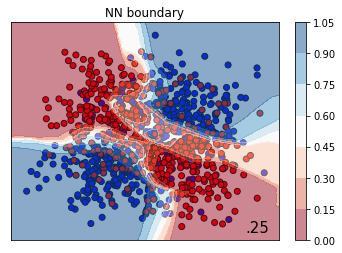

In [144]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

score = net.score(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = net.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('NN boundary')
ax.text(
    xx.max() - 0.3,
    yy.min() + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)
plt.colorbar()
plt.show()

In [145]:
irm = net.get_internal_representation(X, penultimate=False)